# IDS Assignment 2
Document your results as well as the way you obtained them in this jupyter notebook. A seperate report (pdf, word etc.) is _not_ required. However, it is necessary that you provide the python code leading to your results as well as textual answers to the assignment questions in this notebook. 

Do not change the general structure of this notebook, but you can add further markdown or code cells to explain your solutions if necessary. In the end, submit this file in moodle.

In [1]:
# lib for preprocessing/visualization
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
# lib for clustering/frequent itemsets & association rule mining
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules as arule
# lib for text mining
import nltk
import string
import multiprocessing
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, r2_score
# lib for process mining
import pm4py
from collections import Counter
from pm4py.visualization.petrinet import factory as pn_vis_factory
from pm4py.objects.log.importer.xes import factory as xes_importer
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.visualization.process_tree import factory as pt_vis_factory
from pm4py.evaluation.replay_fitness import factory as replay_fitness_factory
from pm4py.algo.conformance.tokenreplay import factory as token_based_replay_factory

%matplotlib inline

# Preprocessing and Data Quality 


###Question 1 (Order cancellations)
Invoices with a InvoiceNo starting with the letter ‘c’ are order cancellations. Would you recommend keeping the order cancellation in your data set? Also provide a reason for your recommandation. 

<font color='blue'>
Your answer:

I don't recommend keeping the order cancellation in this data set. Those data are outliers and should be removed. Besides, they might influence the association rule mining since they will be treated as transactions if they are remained.

In [2]:
%%time
#Modify the data set according to your recommendation
path_to_file = 'Assignment2Datasets/Online Retail.xlsx'
retail_origin = pd.read_excel(path_to_file)
index = [i for i in range(len(retail_origin)) if type(retail_origin['InvoiceNo'][i]) == int]
print('Cancel order percentage: ', 1-len(index)/len(retail_origin))
retail_clean = retail_origin.iloc[index, :]
retail_clean = retail_clean.reset_index(drop=True)

Cancel order percentage:  0.017144944999990752
CPU times: user 41.8 s, sys: 506 ms, total: 42.3 s
Wall time: 42.5 s


###Question 2 (Empty values)
The attributes Description and CustomerID contain empty values. The Country attribute contains an “unspecified” value. For each of the three attributes reason how you would handle these values and why. 

In [3]:
# "Description" missing value percentage
des_missing = retail_clean.loc[pd.isna(retail_clean['Description']) == True]
des_perc = len(des_missing) / len(retail_clean)

# "CustomerID" missing value percentage
id_missing = retail_clean.loc[pd.isna(retail_clean['CustomerID']) == True]
id_perc = len(id_missing) / len(retail_clean)

# "Country" missing value percentage
cty_missing = retail_clean.loc[retail_clean['Country'] == 'Unspecified']
cty_perc = len(cty_missing) / len(retail_clean)

print('Missing value percentage: ')
print('For "Description" column: ', des_perc)
print('For "CustomerID" column: ', id_perc)
print('For "Country" column: ', cty_perc)

Missing value percentage: 
For "Description" column:  0.0027299114937910473
For "CustomerID" column:  0.2528904393017134
For "Country" column:  0.0008373731267061947


<font color='blue'>
Your answer:

From above observation, we notice that only a tiny part of data for "Country" is missing and we need this attribute to find association rules later, therefore, we could simply remove those data and assume there is no significant influence for the data analysis. And the "Description" is simply a redudant column to "Stockcode", which can remain unchanged. However, there are about 25% of data for "CustomerID" are missing, which cannot be ignored. Considered that later we just need to do clustering and association rule mining, we don't really care so much about some specific customers, therefore, we could fill out those missing CustomerID by creating a imaginary customer id 99999.

In [4]:
#Modify the data set according to your recommendation
retail_data = retail_clean.copy()
# remove Country missing data
retail_data = retail_data.loc[retail_data['Country'] != 'Unspecified']
# fill missing customerid with 99999
retail_data = retail_data.fillna(99999)

###Question 3 (Outliers/Noise)
Explore into the attributes Quantity and UnitPrice by plotting each attribute visually. Do these attributes contain noise and/or outliers? If so, reason how you would handle them and modify your data set accordingly.


[Text(0,0,'Quantity'), Text(0,0,'UnitPrice')]

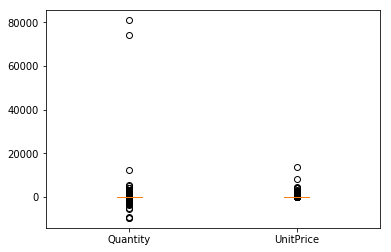

In [5]:
#your code
data = [retail_data['Quantity'], retail_data['UnitPrice']]
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['Quantity', 'UnitPrice'])

<font color='blue'>
Your explanation:

These two attributes both contain outliers, therefore, in a simple way, we could remove those outliers.

In [6]:
# make sure the quantity and unitprice is larger than 0
retail_data = retail_data.loc[(retail_data['Quantity'] > 0) & (retail_data['UnitPrice']) > 0]
old_whiskers = []
# make sure that there are no outliers
while True:
    
    quantity_box = plt.boxplot(retail_data['Quantity'])
    quantity_whiskers = [item.get_ydata()[1] for item in quantity_box['whiskers']]

    unitprice_box = plt.boxplot(retail_data['UnitPrice'])
    unitprice_whiskers = [item.get_ydata()[1] for item in unitprice_box['whiskers']]
    
    # remove outliers --> value beyond upper_whisker and lower_whisker
    retail_data = retail_data.loc[(retail_data['Quantity'] <= quantity_whiskers[1]) &  
                                 (retail_data['Quantity'] >= quantity_whiskers[0]) &
                                 (retail_data['UnitPrice'] <= unitprice_whiskers[1]) &
                                 (retail_data['UnitPrice'] >= unitprice_whiskers[0])
                                ]
    whiskers = quantity_whiskers + unitprice_whiskers
    if old_whiskers == whiskers:
        break
    old_whiskers = whiskers
plt.close()

#Visualization

[Text(0,0,'Quantity'), Text(0,0,'UnitPrice')]

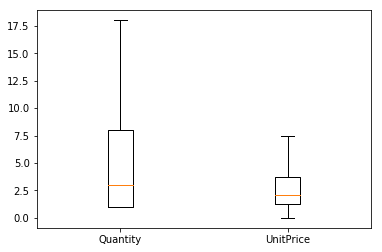

In [7]:
# make sure there are no outliers in boxplot
data = [retail_data['Quantity'], retail_data['UnitPrice']]
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['Quantity', 'UnitPrice'])

###Question 4 (Stream graph)
Create a stream graph that visualizes the number  of purchases (invoices) per country over time.

4. (a) Modify the data set to only contain purchases made in the countries Belgium, Ireland (EIRE), France, Germany, the Netherlands, Norway, Portugal, Spain and Switzerland.

In [8]:
#your modification
retail_country = retail_data.copy()
countries = ['Belgium', 'EIRE', 'France', 'Germany', 'Netherlands', 'Norway', 'Portugal', 'Spain', 'Switzerland']
retail_country = retail_country.loc[retail_country['Country'].isin(countries)]

4. (b) Modify the data set such that it shows per month for each country how many purchases were made (i.e. how many invoices were created).

In [9]:
#your modification
retail_country['InvoiceDate'] = retail_country['InvoiceDate'].apply(
        lambda x: pd.to_datetime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m'))

time_series = retail_country['InvoiceDate'].unique()
country_purchases = {}
for c in countries:
    df_country = retail_country[retail_country['Country'] == c]
    purchases = []
    for t in time_series:
        purchases.append(len(df_country.loc[df_country['InvoiceDate'] == t]))
    country_purchases[c] = purchases

df_purchases = pd.DataFrame(country_purchases, index=time_series).transpose()

In [10]:
df_purchases['total_sales'] = df_purchases.sum(axis=1)
df_purchases.sort_values('total_sales', ascending=False)

,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,total_sales
Germany,299,554,198,381,297,493,489,542,599,511,898,776,219,6256
France,297,454,292,352,164,463,382,322,420,732,614,1127,238,5857
EIRE,236,81,317,377,222,420,363,365,428,816,511,718,225,5079
Spain,58,307,65,132,63,54,134,118,208,163,205,236,59,1802
Belgium,50,40,86,110,90,101,178,87,131,140,183,182,65,1443
Switzerland,32,82,59,32,55,99,50,125,195,110,265,122,0,1226
Portugal,98,65,41,76,56,73,41,54,6,59,363,118,73,1123
Norway,49,0,28,17,0,0,107,34,55,102,88,102,27,609
Netherlands,17,32,14,40,3,35,117,9,26,38,59,61,6,457


4. (c) Use the modified data to create a stream graph. 

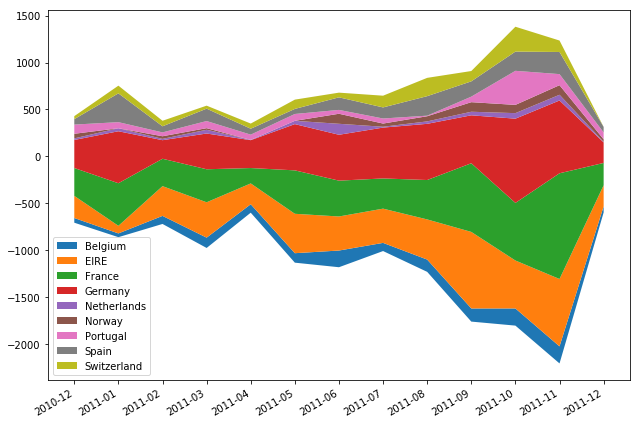

In [11]:
#your code
countries = df_purchases.index

purchase_num = df_purchases.iloc[:, :-1].values

fig, ax = plt.subplots(figsize=(9, 6))
#modifying the axis
ax.stackplot(df_purchases.columns[:-1], purchase_num, labels=countries, baseline='wiggle')
ax.legend(loc='lower left')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

4. (d) Use this graph to compare the purchases made by each country. 

<font color='blue'>
Your answer:

Ireland, France and Germany generally have more sales compared to other countries during the same time. 
Netherlands, Norwary have the least sales history compared to other countries. 

During September to November of year 2011 have particular high sales, while Aprial and December of 2011 has particular low sales.

### Question 5 (Heat map)
Create a heat map that visualizes how much (in sterling) each country purchases per month. 

5. (a) Modify the data set to only contain purchases made in the countries Belgium, Ireland (EIRE), France, Germany, the Netherlands, Norway, Portugal, Spain and Switzerland. (Or use the version of the data set that you created for question 4 a).

In [12]:
#your modification
retail_country.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12,3.75,12583.0,France
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12,0.85,12583.0,France
33,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,2010-12,2.95,12583.0,France
41,536370,21913,VINTAGE SEASIDE JIGSAW PUZZLES,12,2010-12,3.75,12583.0,France
1099,536527,22809,SET OF 6 T-LIGHTS SANTA,6,2010-12,2.95,12662.0,Germany


5. (b) Modify the data set such that it shows per month how much money (in sterling) was spent in the shop per country.

In [13]:
#your modification

time_series = retail_country['InvoiceDate'].unique()
country_money = {}
for c in countries:
    df_country = retail_country[retail_country['Country'] == c]
    money = []
    for t in time_series:
        df_m = df_country.loc[df_country['InvoiceDate'] == t]
        df_money = df_m.copy()
        df_money['money'] = df_money['Quantity'] * df_money['UnitPrice']
        money.append(sum(df_money['money']))
    country_money[c] = money

df_money_spend = pd.DataFrame(country_money, index=time_series).transpose()

In [14]:
df_money_spend['total_spend'] = df_money_spend.sum(axis=1)
df_money_spend.sort_values('total_spend', ascending=False)

,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,total_spend
Germany,5886.40,9152.95,3980.37,6405.09,5659.70,9001.48,7089.81,8768.89,10619.66,9092.05,16430.46,13561.47,4050.67,109699.00
France,4497.11,8448.00,5050.02,5620.45,2278.29,7833.54,6820.19,5275.14,6859.47,13199.41,8883.31,16537.17,4018.83,95320.93
EIRE,4965.91,1451.82,5028.42,6948.68,3528.40,7973.09,6547.42,6487.55,7184.02,15139.49,9280.99,14160.43,4233.64,92929.86
Spain,562.13,4354.26,1054.51,2271.79,1030.14,1093.78,1955.48,1291.43,1901.61,2707.63,2885.94,3620.48,219.63,24948.81
Belgium,739.07,678.35,1417.15,1966.34,1399.32,1573.40,2937.54,1437.82,2053.45,2474.70,3201.56,3445.49,953.00,24277.19
Switzerland,774.56,1461.63,1017.22,570.89,965.31,1989.37,1116.82,1445.44,3399.90,1988.69,4413.63,2896.50,0.00,22039.96
Portugal,1761.04,1320.55,755.28,1326.36,1148.71,544.38,682.16,1043.77,103.10,941.42,3706.55,1553.92,1448.41,16335.65
Norway,1086.32,0.00,502.40,311.01,0.00,0.00,2225.12,552.98,947.32,2295.83,1864.77,2247.25,785.73,12818.73
Netherlands,191.96,931.38,284.50,691.74,38.80,1104.68,1427.11,11.02,679.49,1158.12,742.65,841.57,584.60,8687.62


5. (c) Use the modified data to create a heat map. 

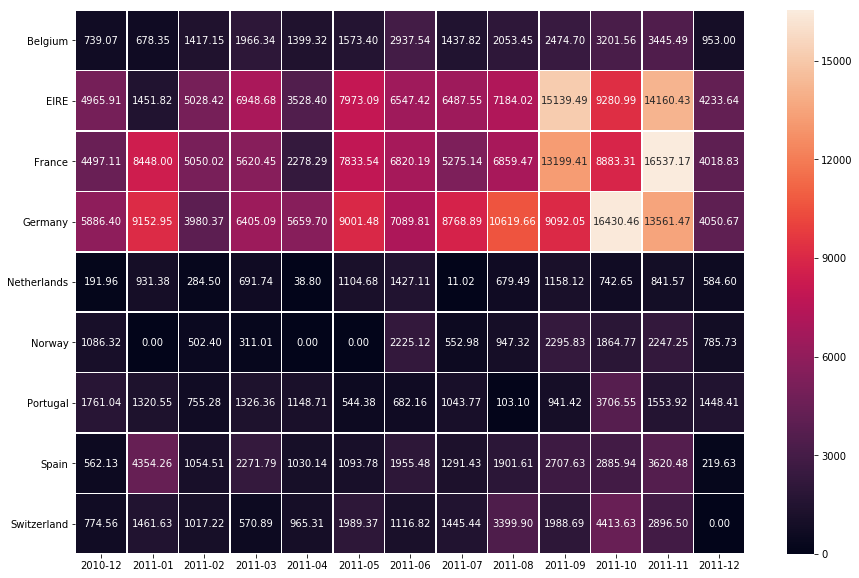

In [15]:
#your code
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_money_spend.iloc[:, :-1], annot=True, fmt=".2f", linewidths=.5, ax=ax)

5. (d) Compare the amount of the purchases over time and between each country. 

<font color='blue'>
Your answer:

Ireland, France and Germany have relatively higher amount of purchases, while Netherlands, Norway and Portugal have lower amount of purchases, which means they spend less money. 

During September to November in year 2011, the amount of purchases are particular high. While in April and December 2011, the amount of purchases is particular low. 

###Question 6 (Interpretation)
Compare the results obtained from the stream graph and the heat map. Is there a relation between the number of purchases and the amount purchased in sterling?


In [16]:
pearson_corr = []
for i in range(len(df_purchases)):
    pearson_corr.append(np.corrcoef(df_purchases.iloc[i, :-1], df_money_spend.iloc[i, :-1])[0, 1])
    
df_corr = pd.DataFrame(pearson_corr, index=countries, columns=['Pearson correlation'])
df_corr.sort_values('Pearson correlation',ascending=False)

,Pearson correlation
EIRE,0.992968
Norway,0.991677
Belgium,0.990534
Germany,0.985022
France,0.980829
Switzerland,0.964879
Portugal,0.945511
Spain,0.936277
Netherlands,0.771346


<font color='blue'>
Your answer:

Yes. They are positive correlated as shown in above Pearson correlation table. Among them, Netherlands may have less correlation, but still, it is highly correlated. 

From both figures, we could argue that Ireland, France and Germany have higher number of sales and they make more money than other countries. While in Netherlands, Norway, they sell less products and make less money. Besides, during September to November in year 2011, nearly all countries sell more products, while in April and December 2011, they sell less products and make less money, which coincides with two graphs. 

# Clustering
Presume that the business analyst would like to cluster transactions with similar types of products into the same group (here don’t consider the quantity of the products). For each product, only use its ‘StockCode’ to represent it. All the results here should be based on the preprocessed data set obtained from question 1 to 3 of this assignment. Presume that this obtained data set from question 1 to 3 has a variable name ‘cluster_dataset’ and is expressed by Pandas DataFrame in your code.

###Question 7 (Data transformation and clustering)
7. (a) Calculate and show the number of occurrences of each product in data set   ‘cluster_dataset’. For example, if a product appears in a transaction, then its occurrence number will be increased by 1 (do not consider the quantity of this product here). Preserve the 100 most frequent products and remove all the other products in ‘cluster_dataset’. For example, if a row in ‘cluster_dataset’ contains unqualified product, then remove this row from ‘cluster_dataset’. Show the new ‘cluster_dataset’ in your result.


In [17]:
# your code
cluster_dataset = retail_data.copy()
cluster_dataset = cluster_dataset.astype('str')
product_occu = {}
df_cluster = cluster_dataset.groupby('StockCode')
for code, data in df_cluster:
    product_occu[code] = len(data)
    
stock_code = []
for code, num in sorted(product_occu.items(), key=lambda x:x[1], reverse=True)[:100]:
    stock_code.append(code)
    
cluster_dataset = cluster_dataset.loc[cluster_dataset['StockCode'].isin(stock_code)]
cluster_dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
17,536367,21754,HOME BUILDING BLOCK WORD,3,2010-12-01 08:34:00,5.95,13047.0,United Kingdom
18,536367,21755,LOVE BUILDING BLOCK WORD,3,2010-12-01 08:34:00,5.95,13047.0,United Kingdom
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047.0,United Kingdom
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France


7. (b) Based on question a, please reorganize the data from ‘cluster_dataset’ and generate a new data set ‘cluster_dataset_new’ which has a suitable format (for k-means) for solving the transaction clustering problem mentioned above. Show the data from ‘cluster_dataset_new’ by using Pandas DataFrame in your result, where the index should be consistent with the values of 'InvoiceNo', the column name should be consistent with the values of 'StockCode' and each element in this DataFrame should have a value 0 or 1.

In [18]:
# your code
cluster_dataset_new = cluster_dataset[['InvoiceNo', 'StockCode']]
cluster_dataset_new = pd.crosstab(cluster_dataset_new.InvoiceNo, cluster_dataset_new.StockCode)
cluster_dataset_new.head()

StockCode,20712,20719,20723,20724,20725,20726,20727,20728,20914,21034,...,82580,84378,84380,84879,84946,85099B,85099C,85099F,85123A,85152
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


7. (c) Try values 2, 3, 4, 5 for parameter 'n_clusters' for the k-means function from Scikit-Learn over the data set ‘cluster_dataset_new’ generated in question b. Show the ‘within cluster variation’ (also called ‘sum of squared distances’) of the generated clusters for each different setting for ‘n_clusters’ in your result. Also write down the value that you have tried for setting 'n_clusters' which can help generate the best clustering results and explain how you make this decision.

In [19]:
%%time
# Ref: https://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means
cluster_ssd = {}
for cluster_num in range(2, 6):
    kmeans = KMeans(cluster_num, init='k-means++').fit(cluster_dataset_new.values)
    cluster_ssd[cluster_num] = kmeans.inertia_

n_clusters = list(cluster_ssd.keys())
distortion = list(cluster_ssd.values())

CPU times: user 7.09 s, sys: 115 ms, total: 7.2 s
Wall time: 4.15 s


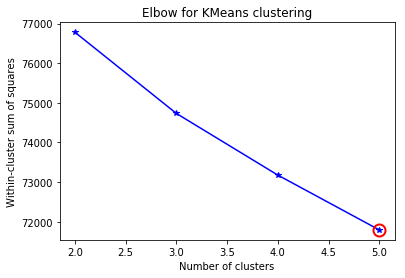

In [20]:
# elbow curve
fig = plt.figure()
best_cluster = 5
plt.plot(n_clusters, distortion, 'b*-')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.plot(best_cluster, cluster_ssd[best_cluster], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')

<font color='blue'>
Your explanation:

I have tried n_clusters from 2 to 5, as plotted in "Elbow for KMeans clustering", 5 clusters should present the best results, since it has the least sum of squared distances

# Frequent Itemsets and Association Rules
 For the clusters output by k-means function with the best 'n_clusters' from question 7, the business analyst now would like to research on the frequent purchase behaviours and specific purchase rules for each cluster.
###Question 8 (Data transformation and mining frequent itemsets and association rules)
8. (a) Set the minimum support for finding the frequent purchase behaviours to 0.2. Please provide the business analyst with the qualified purchase behaviours. For each product, only use its ‘StockCode’ to represent it. Also show the data set prepared for each cluster for mining the frequent behaviours by using Pandas DataFrame in your result, the data set for the cluster k should have the variable name 'fpb_data_k' in your code.

In [21]:
np.random.seed(100) # make results stable
n_cluster = 5 # best number of clusters
# cluster num as key, row num (in datasets) as value
cluster_indices = {key: [] for key in list(range(n_cluster))}

kmeans = KMeans(n_cluster, init='k-means++').fit(cluster_dataset_new.values)
clusters = kmeans.labels_
stockCode_name = cluster_dataset_new.columns

for i in range(len(clusters)):
    cluster_indices[clusters[i]].append(i)
    
# for each cluster obtain a dataframe to show frequent itemsets
fpb_data_k = {key: [] for key in list(range(n_cluster))}
# cluster num as key, a list of transactions for this cluster as value
# preparation for TransactionEncoder
trans_data_k = {key: [] for key in list(range(n_cluster))}
for i in range(n_cluster):
    for j in cluster_indices[i]:
        # get product code for each row (transaction)
        transaction = list(stockCode_name[np.where(cluster_dataset_new.iloc[j] == 1)])
        trans_data_k[i].append(transaction)

for i in range(n_cluster):
    te = TransactionEncoder()
    te_ary = te.fit(trans_data_k[i]).transform(trans_data_k[i])
    data = pd.DataFrame(te_ary, columns = te.columns_)
    frequent_itemsets = apriori(data, min_support = 0.2, use_colnames = True)
    fpb_data_k[i] = frequent_itemsets

In [22]:
# frequent purchase behaviours for cluster 0
fpb_data_k[0]

,support,itemsets


In [23]:
# frequent purchase behaviours for cluster 1
fpb_data_k[1]

,support,itemsets
0,0.220854,(21733)
1,0.947140,(85123A)
2,0.208545,"(85123A, 21733)"


In [24]:
# frequent purchase behaviours for cluster 2
fpb_data_k[2]

,support,itemsets
0,0.471322,(20712)
1,0.526185,(20719)
2,0.408978,(20723)
3,0.536160,(20724)
4,0.458853,(20725)
5,0.349127,(20726)
6,0.339152,(20727)
7,0.254364,(20728)
8,0.301746,(20914)
9,0.413965,(21080)


In [25]:
# frequent purchase behaviours for cluster 3
fpb_data_k[3]

,support,itemsets
0,0.322425,(20712)
1,0.321463,(21928)
2,0.286814,(21929)
3,0.214629,(21930)
4,0.451396,(21931)
5,0.250241,(22385)
6,0.503369,(22386)
7,0.462945,(22411)
8,0.230029,(23199)
9,0.242541,(23203)


In [26]:
# frequent purchase behaviours for cluster 4
fpb_data_k[4]

,support,itemsets
0,0.530919,(20725)
1,0.424912,(20726)
2,0.532686,(20727)
3,0.510601,(20728)
4,0.553004,(22382)
5,0.530035,(22383)
6,0.476148,(22384)
7,0.290636,(22662)
8,0.206714,(23203)
9,0.418728,(23206)


8. (b) Furthermore, the business analyst would like to analyze the purchase behaviour of the citizens from ‘United Kingdom’ for each cluster. Specifically speaking, he wants to discover if there exist some rules which indicate that the citizens from ‘United Kingdom’ tend to buy some specific products for each cluster. Set the minimum support to 0.2, minimum confidence to 0.7. Please discover and show such rules (only show the rules with ‘United Kingdom’ appearing in antecedents in the rules) for each cluster for the business analyst. Also show the data sets prepared for each cluster for mining the relevant rules by using Pandas DataFrame in you result, the data set for cluster k should have the variable name 'r_data_k' in your code.

In [27]:
cluster_dataset_uk = cluster_dataset.loc[cluster_dataset['Country'] == 'United Kingdom', ['InvoiceNo', 'StockCode']]
# row index for purchase behaviour from 'United Kingdom'
uk_index = cluster_dataset_uk.index
stockCode_name = cluster_dataset_new.columns
uk_cluster_indices = {key: [] for key in list(range(n_cluster))}

for i in range(len(clusters)):
    if i in uk_index:
        uk_cluster_indices[clusters[i]].append(i)
    

uk_fpb_data_k = {key: [] for key in list(range(n_cluster))}
uk_trans_data_k = {key: [] for key in list(range(n_cluster))}

for i in range(n_cluster):
    for j in uk_cluster_indices[i]:
        # get product code for each row (transaction)
        uk_transaction = list(stockCode_name[np.where(cluster_dataset_new.iloc[j] == 1)])
        uk_transaction += ['United Kingdom']
        uk_trans_data_k[i].append(uk_transaction)

for i in range(n_cluster):
    te = TransactionEncoder()
    uk_te_ary = te.fit(uk_trans_data_k[i]).transform(uk_trans_data_k[i])
    uk_data = pd.DataFrame(uk_te_ary, columns = te.columns_)
    uk_frequent_itemsets = apriori(uk_data, min_support = 0.2, use_colnames = True)
    uk_fpb_data_k[i] = uk_frequent_itemsets
    
# for each cluster, save a dataframe to show association rules
r_data_k = {key: [] for key in list(range(n_cluster))}
for i in range(n_cluster):
    if len(uk_fpb_data_k[i]) == 0:
        r_data_k[i] = None
    else:
        rules_association = arule(uk_fpb_data_k[i], metric = 'confidence', min_threshold = 0.7)
        rules_association = rules_association[rules_association['antecedents'].apply(lambda x : 'United Kingdom' in x)]
        r_data_k[i] = rules_association


In [28]:
# association rules for cluster 0
r_data_k[0]

""


In [29]:
# association rules for cluster 1
r_data_k[1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(United Kingdom),(85123A),1.000000,0.95679,0.956790,0.956790,1.000000,0.000000,1.000000
4,"(United Kingdom, 21733)",(85123A),0.228395,0.95679,0.216049,0.945946,0.988666,-0.002477,0.799383


In [30]:
# association rules for cluster 2
r_data_k[2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
349,"(United Kingdom, 21175)",(20712),0.244444,0.488889,0.200000,0.818182,1.673554,0.080494,2.811111
395,"(20712, United Kingdom)",(21731),0.488889,0.622222,0.377778,0.772727,1.241883,0.073580,1.662222
552,"(20712, United Kingdom)",(22697),0.488889,0.666667,0.377778,0.772727,1.159091,0.051852,1.466667
608,"(United Kingdom, 23201)",(20712),0.377778,0.488889,0.266667,0.705882,1.443850,0.081975,1.737778
611,"(23202, United Kingdom)",(20712),0.311111,0.488889,0.222222,0.714286,1.461039,0.070123,1.788889
617,"(20712, United Kingdom)",(85099B),0.488889,0.688889,0.377778,0.772727,1.121701,0.040988,1.368889
636,"(20723, United Kingdom)",(20719),0.400000,0.533333,0.288889,0.722222,1.354167,0.075556,1.680000
675,"(United Kingdom, 20719)",(20724),0.533333,0.577778,0.377778,0.708333,1.225962,0.069630,1.447619
718,"(United Kingdom, 21232)",(20719),0.377778,0.533333,0.288889,0.764706,1.433824,0.087407,1.983333
790,"(United Kingdom, 22197)",(20719),0.244444,0.533333,0.200000,0.818182,1.534091,0.069630,2.566667


In [31]:
# association rules for cluster 3
r_data_k[3]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,(United Kingdom),(85099B),1.000000,0.790476,0.790476,0.790476,1.000000,0.000000,1.000000
20,"(United Kingdom, 21928)",(85099B),0.295238,0.790476,0.228571,0.774194,0.979401,-0.004807,0.927891
23,"(United Kingdom, 21929)",(85099B),0.295238,0.790476,0.209524,0.709677,0.897785,-0.023855,0.721693
27,"(United Kingdom, 21931)",(85099B),0.428571,0.790476,0.304762,0.711111,0.899598,-0.034014,0.725275
30,"(22386, United Kingdom)",(85099B),0.466667,0.790476,0.352381,0.755102,0.955250,-0.016508,0.855556
33,"(United Kingdom, 22411)",(85099B),0.380952,0.790476,0.266667,0.700000,0.885542,-0.034467,0.698413


In [32]:
# association rules for cluster 4
r_data_k[4]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
45,"(20727, United Kingdom, 20728)",(22384),0.277778,0.486111,0.201389,0.725,1.491429,0.066358,1.868687


# Text Mining
###Question 12 (Model based on binary document-term matrix)
Perform preprocessing on the corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a binary document-term matrix; train a logistic classifier.

In [33]:
df_train_data = pd.read_csv('Assignment2Datasets/pg_train.csv', sep='#', encoding='latin-1', header=None, )
df_test_data = pd.read_csv('Assignment2Datasets/pg_test.csv', sep='#', encoding='latin-1', header=None)
df_train_data.head()

,0,1
0,austen,[ Emma by Jane Austen 1816 ] VOLUME I CHAPTER ...
1,austen,Sixteen years had Miss Taylor been in Mr . Woo...
2,austen,It was Miss Taylor ' s loss which first brough...
3,austen,The want of Miss Taylor would be felt every ho...
4,austen,"He could not meet her in conversation , ration..."


In [34]:
# preprocessing for lowercase, no punctuation, tokenization, stemming, stopword removal
def preprocessing(text):
    
    text = text.lower()
    
    # remove digits
    dig_translator = str.maketrans('', '', '0123456789')
    text = text.translate(dig_translator)

    # remove punctuation
    str_translator = str.maketrans('', '', string.punctuation)
    text = text.translate(str_translator)
    text = text.strip()

    # tokenize sentences
    word_tokens = word_tokenize(text)
    # stemming
    snow = SnowballStemmer('english', ignore_stopwords=True)
    stem_tokens = [snow.stem(w) for w in word_tokens]

    # remove stop words
    stop_words = stopwords.words('english')
    filtered_tokens = [w for w in stem_tokens if not w in stop_words]
    
    # concatenated preprocessed text as a new document
    filtered_str = ''
    for w in filtered_tokens:
        filtered_str += w + ' '
        
    return filtered_str

In [35]:
%%time
preprocess_data = pd.DataFrame(df_train_data)
preprocess_data.columns = ['target', 'documents']
preprocess_data['documents'] = preprocess_data['documents'].apply(preprocessing)

CPU times: user 7.59 s, sys: 287 ms, total: 7.88 s
Wall time: 7.91 s


In [36]:
train_docs = preprocess_data.documents
train_binary_vect = CountVectorizer(binary=True)
train_counts = train_binary_vect.fit_transform(train_docs)
# binany document term matrix
df_doc_term = pd.DataFrame(train_counts.toarray(), columns=train_binary_vect.get_feature_names())
df_doc_term.head()

,aback,abandon,abbey,abbot,abbrevi,abdic,abelard,aberr,abhomin,abhor,...,zeal,zealous,zem,zigzag,zmite,zoetrop,zola,zoolog,zso,zumpt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
dt_train_data = df_doc_term.values
train_target_data = preprocess_data.target

dt_clf = LogisticRegression(solver = 'liblinear', multi_class = 'ovr')
dt_clf.fit(dt_train_data, train_target_data)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

###Question 13 (Model based on document-term matrix of counts)
Perform preprocessing on the corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a document-term matrix of counts; train a logistic classifier.


In [38]:
# your code
train_count_vect = CountVectorizer()
train_counts = train_count_vect.fit_transform(preprocess_data.documents)
df_doc_term_count = pd.DataFrame(train_counts.toarray(), columns=train_count_vect.get_feature_names())

dtc_train_data = df_doc_term_count.values

dt_count_clf = LogisticRegression(solver = 'liblinear', multi_class = 'ovr')
dt_count_clf.fit(dtc_train_data, train_target_data)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

###Question 14 (Model based on tf-idf document-term matrix)
Perform preprocessing on the corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a tf-idf scores document-term matrix; train a logistic classifier.


In [39]:
# your code
tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(df_doc_term_count.values)
tfidf_train_data = train_tfidf.toarray()

tf_idf_clf = LogisticRegression(solver='liblinear', multi_class='ovr')
tf_idf_clf.fit(tfidf_train_data, train_target_data)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

###Question 15 (Model based on doc2vec)
Perform preprocessing on the corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a doc2vec embedding in order to reduce the dimension of the document vector to 300; use the doc2vec model you just trained to convert the training set to a set of document vectors; train a logistic classifier.


In [40]:
# your code

cores = multiprocessing.cpu_count()
preprocess_tagged = preprocess_data.apply(
    lambda r: TaggedDocument(words=word_tokenize(r.documents), tags=r.target), axis=1)

# feature dimension set to 300
model = Doc2Vec(preprocess_tagged, dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores)
doc2vec_train_data =  [model.infer_vector(doc.words) for doc in preprocess_tagged]

doc2vec_clf = LogisticRegression(solver='liblinear', multi_class='ovr')
doc2vec_clf.fit(doc2vec_train_data, train_target_data)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
del dt_train_data
del dtc_train_data
del tfidf_train_data
del doc2vec_train_data
del df_doc_term
del df_doc_term_count

###Question 16 (Evaluation)
16. (a) Predict the classification with the four models on the test data.


In [42]:
df_test_data.columns = ['target', 'documents']
df_test_data['documents'] = df_test_data['documents'].apply(preprocessing)
test_target = df_test_data['target']

In [43]:
# transform test data to document-term matrix
test_binany = train_binary_vect.transform(df_test_data.documents)
test_doc_term = pd.DataFrame(test_binany.toarray(), columns=train_binary_vect.get_feature_names())
dt_test_data = test_doc_term.values
dt_test_pred = dt_clf.predict(dt_test_data)

# transform test data to document-term count matrix
test_counts = train_count_vect.transform(df_test_data.documents)
test_doc_term_count = pd.DataFrame(test_counts.toarray(), columns=train_count_vect.get_feature_names())
dtc_test_pred = dt_count_clf.predict(test_doc_term_count.values)

# transform test data to tfidf document-term matrix
test_tfidf = tfidf_transformer.transform(test_counts)
test_tfidf_data = test_tfidf.toarray()
tfidf_test_pred = tf_idf_clf.predict(test_tfidf_data)

# transform test data to doc2vec 
test_tagged = df_test_data.apply(
    lambda r: TaggedDocument(words=word_tokenize(r.documents), tags=r.target), axis=1)

test_doc2vec_data =  [model.infer_vector(doc.words) for doc in test_tagged]
doc2vec_test_pred = doc2vec_clf.predict(test_doc2vec_data)

In [44]:
del dt_test_data
del test_doc_term
del test_doc_term_count
del test_tfidf_data
del test_doc2vec_data

16. (b) Obtain confusion matrices for the four different models.


In [45]:
# document-term confusion matrix
dt_conf = confusion_matrix(test_target, dt_test_pred)
print('document-term model confusion matrix \n', dt_conf)
# document-term count confusion matrix
dtc_conf = confusion_matrix(test_target, dtc_test_pred)
print('document-term count model confusion matrix \n', dtc_conf)
# tf-idf document-term confusion matrix
tf_idf_conf = confusion_matrix(test_target, tfidf_test_pred)
print('tf-idf model confusion matrix \n', tf_idf_conf)
# doc2vec confusion matrix
doc2vec_conf = confusion_matrix(test_target, doc2vec_test_pred)
print('doc2vec model confusion matrix \n', doc2vec_conf)

document-term model confusion matrix 
 [[680   6   3]
 [ 13 496   6]
 [  0   0 301]]
document-term count model confusion matrix 
 [[676   8   5]
 [ 18 493   4]
 [  0   0 301]]
tf-idf model confusion matrix 
 [[682   7   0]
 [ 10 505   0]
 [  0   3 298]]
doc2vec model confusion matrix 
 [[685   3   1]
 [ 18 494   3]
 [  1   2 298]]


16. (c) Obtain accuracy and f1 score for the four different models.


In [46]:
# your code
target_dumm = pd.get_dummies(test_target, drop_first=True)
dt_dumm = pd.get_dummies(dt_test_pred, drop_first=True)
dtc_dumm = pd.get_dummies(dtc_test_pred, drop_first=True)
tfidf_dumm = pd.get_dummies(tfidf_test_pred, drop_first=True)
doc2vec_dumm = pd.get_dummies(doc2vec_test_pred, drop_first=True)

dt_metric = [accuracy_score(target_dumm, dt_dumm), precision_score(target_dumm, dt_dumm, average='macro'),
               recall_score(target_dumm, dt_dumm, average='macro'),f1_score(target_dumm, dt_dumm, average='macro')]
dt_df = pd.DataFrame(dt_metric, index=['Accuracy', 'Precision', 'Recall', 'F1'], 
                       columns=['document-term model'])

dtc_metric = [accuracy_score(target_dumm, dtc_dumm), precision_score(target_dumm, dtc_dumm, average='macro'),
               recall_score(target_dumm, dtc_dumm, average='macro'),f1_score(target_dumm, dtc_dumm, average='macro')]
dtc_df = pd.DataFrame(dtc_metric, index=['Accuracy', 'Precision', 'Recall', 'F1'], 
                       columns=['document-term count model'])

tfidf_metric = [accuracy_score(target_dumm, tfidf_dumm), precision_score(target_dumm, tfidf_dumm, average='macro'),
               recall_score(target_dumm, tfidf_dumm, average='macro'),f1_score(target_dumm, tfidf_dumm, average='macro')]
tfidf_df = pd.DataFrame(tfidf_metric, index=['Accuracy', 'Precision', 'Recall', 'F1'], 
                       columns=['tfidf document-term model'])

doc2vec_metric = [accuracy_score(target_dumm, doc2vec_dumm), precision_score(target_dumm, doc2vec_dumm, average='macro'),
               recall_score(target_dumm, doc2vec_dumm, average='macro'),f1_score(target_dumm, doc2vec_dumm, average='macro')]
doc2vec_df = pd.DataFrame(doc2vec_metric, index=['Accuracy', 'Precision', 'Recall', 'F1'], 
                       columns=['doc2vec model'])
pd.concat([dt_df, dtc_df, tfidf_df, doc2vec_df], axis=1)

,document-term model,document-term count model,tfidf document-term model,doc2vec model
Accuracy,0.981395,0.976744,0.986711,0.981395
Precision,0.979508,0.977500,0.990291,0.988367
Recall,0.981553,0.978641,0.985308,0.974628
F1,0.980344,0.977871,0.987787,0.981375


16. (d) Briefly comment on the quality of the predictions for the four models.

<font color='blue'>
Your comment:


In general, every model can perform pretty well, all achieving the accuracy more than 95%. If I have to say, the TF-IDF document-term model performs the best, with a tiny advantage on accuracy and f1 score. 

# Process Mining
For this part, refer to the online docs of pm4py. You will find particularly of interest the documentation on filtering (https://pm4py.github.io/filtering.html, or on the new website http://pm4py.pads.rwth-aachen.de/documentation/filtering-logs/). 
important: if you did not do it in the instruction, you should make sure to have the latest pm4py version: to get it is sufficient to type `pip install pm4py --upgrade` from any terminal emulator on Windows  (command prompt, PowerShell, etc) or any terminal on *nix systems. For the details, refer to the study guide and the Process Mining instruction.
###Question 17 (Trace frequency)
17. (a) Use the provided event log and identify the least frequent traces and the most frequent traces.


In [47]:
log = xes_importer.import_log('./Assignment2Datasets/event_log.xes')

In [48]:
freq_traces = []
for trace in log:
    one_trace = []
    for events in trace:
        one_trace.append(events['concept:name'])
    freq_traces.append(tuple(one_trace))

freq_traces = Counter(freq_traces)

print('most frequent traces: {0}, with amount: {1}'.format(
    freq_traces.most_common()[0][0], freq_traces.most_common()[0][1]))
print('least frequent traces: {0}, with amount: {1}'.format(
    freq_traces.most_common()[-1][0], freq_traces.most_common()[-1][1]))

most frequent traces: ('Assigned Severity', 'Waiting', 'Under Processing', 'Solves', 'Closed'), with amount: 12188
least frequent traces: ('Assigned Severity', 'Under Processing', 'Waiting', 'Solves', 'Closed'), with amount: 2251


###Question 18 (Process Discovery and Conformance Checking using first filtered event log)
18. (a) Remove the two least frequent traces and create a new event log out of the original event log without the two least frequent traces.

In [49]:
least_freq_traces = [freq_traces.most_common()[-1][0], freq_traces.most_common()[-2][0]]
print('least frequent two traces: \n{0} \n{1}'.format(
    least_freq_traces[0], least_freq_traces[1]))

least frequent two traces: 
('Assigned Severity', 'Under Processing', 'Waiting', 'Solves', 'Closed') 
('Assigned Severity', 'Under Processing', 'Under Processing', 'Waiting', 'Solves', 'Closed')


In [50]:
filtered_log = []
for trace in log:
    one_trace = []
    for events in trace:
        one_trace.append(events['concept:name'])
    if tuple(one_trace) not in least_freq_traces:
        filtered_log.append(trace)

18. (b) Use Inductive miner algorithm to discover the process model based on you new event log (the filtered log without two least frequent traces).


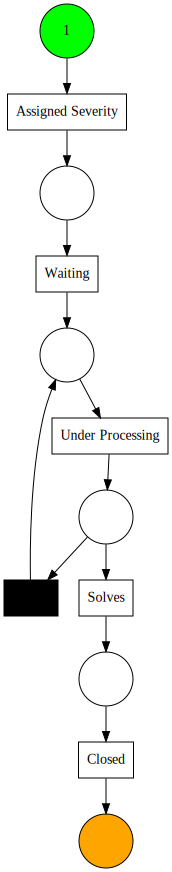

In [51]:
# show petri nets
petri, initial_marking, final_marking = inductive_miner.apply(filtered_log)
pn_vis_factory.apply(petri, initial_marking, final_marking)

18. (c) Do the token replay conformance checking using your discovered model and the original event log. Does your process model fit?


In [52]:
# Mining for a Petri net
token_replay_result = token_based_replay_factory.apply(log, petri, initial_marking, final_marking)
trace_fit = sum([1 for i in range(len(token_replay_result)) if token_replay_result[i]['trace_is_fit'] == True])
print('percentage of trace is fit: ', trace_fit / len(log))

# example
print('\n first log data after token replay: \n', token_replay_result[0])

percentage of trace is fit:  0.8255312986495782

 first log data after token replay: 
 {'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [Assigned Severity, Waiting, Under Processing, Solves, Closed], 'reached_marking': ['sink:1'], 'enabled_transitions_in_marking': set(), 'transitions_with_problems': [], 'missing_tokens': 0, 'consumed_tokens': 5, 'remaining_tokens': 0, 'produced_tokens': 5}


Your explanation:

Yes, this process model fit the event log well, but still there are many traces that are not fit. 

18. (ci) Calculate the fitness of your model.

In [53]:
# your code
fitness = replay_fitness_factory.apply(log, petri, initial_marking, final_marking)

print('percentage of fit traces: ', fitness['perc_fit_traces'])
print('average fitness: ', fitness['average_trace_fitness'])
print('log fitness: ', fitness['log_fitness'])

percentage of fit traces:  82.55312986495782
average fitness:  0.9422531165900576
log fitness:  0.9681466352032891


18. (cii) Are there any deviations between the process model and the event log?

Your explanation:

Yes, there are deviations between the process model and the event log. The process model is built based on frequent traces, therefore, if infrequent traces in the original data are replayed using this process model, it might occur missing tokens and remaining tokens, causing the deviation, which can be see that the fitness is not 1. 

###Question 19 (Process Discovery and Conformance Checking using second filtered event log)
19. (a) Now use the original event log and remove the two most frequent traces, and discover the model based on your new event log(the filtered log without two most frequent traces).


In [54]:
most_freq_traces = [freq_traces.most_common(2)[0][0], freq_traces.most_common(2)[1][0]]
print('most frequent two traces: \n{0} \n{1}'.format(most_freq_traces[0], most_freq_traces[1]))

filtered_log_2 = []
for trace in log:
    one_trace = []
    for events in trace:
        one_trace.append(events['concept:name'])
    if tuple(one_trace) not in most_freq_traces:
        filtered_log_2.append(trace)

most frequent two traces: 
('Assigned Severity', 'Waiting', 'Under Processing', 'Solves', 'Closed') 
('Assigned Severity', 'Waiting', 'Under Processing', 'Under Processing', 'Solves', 'Closed')


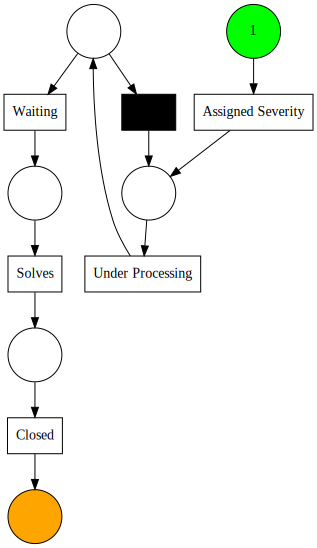

In [55]:
# show petri nets
petri_2, initial_marking_2, final_marking_2 = inductive_miner.apply(filtered_log_2)
pn_vis_factory.apply(petri_2, initial_marking_2, final_marking_2)

19. (b) Do the token replay conformance checking using your newly discovered model and the original event log. Does your process model fit?

In [56]:
token_replay_result_2 = token_based_replay_factory.apply(log, petri_2, initial_marking_2, final_marking_2)
trace_fit_2 = sum([1 for i in range(len(token_replay_result_2)) if token_replay_result_2[i]['trace_is_fit'] == True])
print('percentage trace is fit: ', trace_fit_2 / len(log))

# example
print('\n first log data after token replay: \n', token_replay_result_2[0])

percentage trace is fit:  0.17446870135042178

 first log data after token replay: 
 {'trace_is_fit': False, 'trace_fitness': 0.6400000000000001, 'activated_transitions': [Assigned Severity, Waiting, Under Processing, Solves, Closed], 'reached_marking': ['p_5:1', 'sink:1'], 'enabled_transitions_in_marking': {Waiting, Under Processing}, 'transitions_with_problems': [Waiting], 'missing_tokens': 1, 'consumed_tokens': 5, 'remaining_tokens': 1, 'produced_tokens': 5}


<font color='blue'>
Your explanation:

No, the model does not fit well, since only 17% of traces are fit. 

19. (bi) Calculate the fitness of your model?

In [57]:
# your code
fitness_2 = replay_fitness_factory.apply(log, petri_2, initial_marking_2, final_marking_2)

print('percentage of fit traces: ', fitness_2['perc_fit_traces'])
print('average fitness: ', fitness_2['average_trace_fitness'])
print('log fitness: ', fitness_2['log_fitness'])

percentage of fit traces:  17.44687013504218
average fitness:  0.7237302535510584
log fitness:  0.8492798455914916


19. (bii)  Is there any deviation inside the process model?

<font color='blue'>
Your explanation:

Yes, there are many deviations inside the process model. The process model is built based on infrequent traces, therefore, if frequent traces in the original data are replayed using this process model, it might occur missing tokens and remaining tokens, causing the deviation, which can be seen that the fitness is not 1. 

###Question 20 (Process Discovery using complete log)
20. (a) Use the complete event log (original event log) and discover your process model using inductive miner.


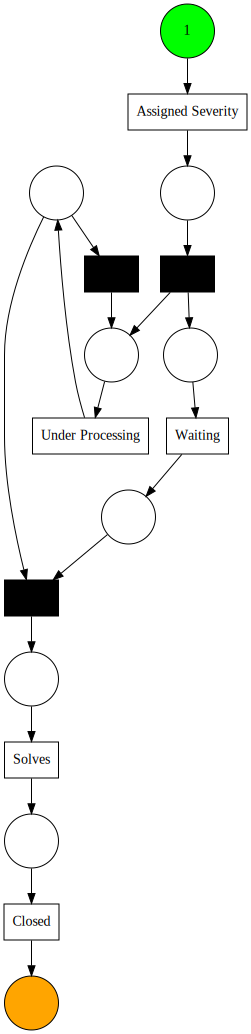

In [58]:
# show petri nets
petri_3, initial_marking_3, final_marking_3 = inductive_miner.apply(log)
pn_vis_factory.apply(petri_3, initial_marking_3, final_marking_3)

20. (b) Do the token replay conformance checking using your newly discovered model and the original event log. Does your process model fit?

In [60]:
# your code


fitness_3 = replay_fitness_factory.apply(log, petri_3, initial_marking_3, final_marking_3)

token_replay_result_3 = token_based_replay_factory.apply(log, petri_3, initial_marking_3, final_marking_3)
trace_fit_3 = sum([1 for i in range(len(token_replay_result_3)) if token_replay_result_3[i]['trace_is_fit'] == True])
print('percentage trace is fit: ', trace_fit_3 / len(log))

print('\npercentage of fit traces: ', fitness_3['perc_fit_traces'])
print('average fitness: ', fitness_3['average_trace_fitness'])
print('log fitness: ', fitness_3['log_fitness'])

percentage trace is fit:  1.0

percentage of fit traces:  100.0
average fitness:  1.0
log fitness:  1.0


<font color='blue'>
Your explanation:

The process model fit the original event log data. Because this process model is built based on all original log data, therefore, the model must fit original data, and as seen, the fitness is 1. 

20. (c) How are these three discovered process models different from each other? Which model is the best fitting to the original log? Why?

<font color='blue'>
Your explanation:

The difference is whether all event logs or part of the event logs data that are used to discover the process model. The best fitting model is that we use comlplete event log to discover the process model, because, in this case, there are no deviations and the fitting is 1. 